### Make a RL Environment about `Non-prehensile task` on table-top scene training with `Deep Latent Policy Gradient`

In [1]:
import mujoco,torch
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import r2rpy, sample_xyzs
from np_env import NonPrehensileMarkovDecisionProcessClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Torch version:[%s]"%(torch.__version__))
print ("MuJoCo version:[%s]"%(mujoco.__version__))

Torch version:[1.13.1+cu116]
MuJoCo version:[2.3.4]


### Parse `UR5e`

In [3]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e',rel_xml_path=xml_path,VERBOSE=False)
# Instantiate MDP
mdp = NonPrehensileMarkovDecisionProcessClass(env,HZ=50,history_total_sec=1.0,history_intv_sec=0.1,VERBOSE=True)

obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.72,0.95],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

[UR5e] Instantiated
   [info] dt:[0.0200] HZ:[50], env-HZ:[500], mujoco_nstep:[10], state_dim:[26], o_dim:[260], a_dim:[7]
   [history] total_sec:[1.00]sec, n:[50], intv_sec:[0.10]sec, intv_tick:[5]
   [history] ticks:[ 0  5 10 15 20 25 30 35 40 45]
Ready.


In [4]:
max_torque = 2
mdp.env.ctrl_ranges[:,0] = -max_torque
mdp.env.ctrl_ranges[:,1] = +max_torque
print ("mdp.env.ctrl_ranges:\n",mdp.env.ctrl_ranges)

mdp.env.ctrl_ranges:
 [[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]


### Loop with `DLPG`

In [5]:
from model.dlpg.dlpg import DeepLatentPolicyGradient
from model.dlpg.dlpg import DeepLatentPolicyGradient
from model.dlpg.cvae import ConditionalVariationalAutoEncoderClass
from model.grpp import GaussianRandomPathClass
from model.dlpg.buffer import BufferClass
from model.utils import torch2np, np2torch, kernel_se, kernel_levse

import torch
import torch.nn as nn 
import json
import sys
sys.path.append('./')

In [6]:
training_data = [json.loads(line) for line in open('./json/np_buffer_v1.json', 'r')]
print("Total: {}".format(len(training_data)))


Total: 122500


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device", device)
model = ConditionalVariationalAutoEncoderClass(x_dim=9, 
                                               c_dim=72, 
                                               z_dim=2, 
                                               h_dims=[128], 
                                               actv_enc=nn.LeakyReLU(),
                                               actv_dec=None,
                                               actv_q   = nn.Softplus(),
                                               actv_out = nn.Tanh(),
                                               device=device).to(device=device)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 1e-3, betas=(0.9, 0.99)) # eps=1e-4
buffer = BufferClass(xdim=9, cdim=72, buffer_limit=len(training_data), device=device)
for idx, data in enumerate(training_data): 
    buffer.store(x=np.array(data["x"]).reshape(-1), c=data["c"], reward=data["reward"])
print("Model Instance.")



Device cuda:0
Model Instance.


### Train

In [7]:
max_iter =30000
batch_size = 256
x_lst = np.linspace(1, max_iter, max_iter)
loss_recon_lst = []
loss_kl_lst = []
unscaled_loss_recon_sum=0;loss_recon_sum=0;loss_kl_sum=0;n_batch_sum=0;train_unscaled_reward_sum=0;train_scaled_reward_sum=0;
for i in range(max_iter):
    if i<int(max_iter*0.1):
        beta =0 
    else: 
        beta = 0.01
    unscaled_loss_recon_sum=0;loss_recon_sum=0;loss_kl_sum=0;n_batch_sum=0;train_unscaled_reward_sum=0;train_scaled_reward_sum=0;
    batch = buffer.sample_batch(sample_method="random",
                                batch_size=batch_size)
    x_batch, c_batch, reward_batch = batch["x"], batch["c"], batch["reward"]
    total_loss_out,loss_info = model.loss_total(x               = x_batch, 
                                                c               = c_batch, 
                                                q               = reward_batch, 
                                                LOSS_TYPE       = 'L1+L2',
                                                recon_loss_gain = 10,
                                                beta            = beta,
                                                STOCHASTICITY   = True)
    optimizer.zero_grad()
    total_loss_out.backward()
    optimizer.step()
    n_batch        = x_batch.shape[0]
    loss_recon_sum = loss_recon_sum + n_batch*loss_info['loss_recon_out']
    unscaled_loss_recon_sum = unscaled_loss_recon_sum+n_batch*loss_info['unscaled_loss_recon_out']
    loss_kl_sum    = loss_kl_sum + n_batch*loss_info['loss_kl_out']
    n_batch_sum    = n_batch_sum + n_batch   
    unscaled_reward_batch_np = torch2np(batch["reward"])
    loss_kl_lst.append(loss_kl_sum.item()/n_batch)
    loss_recon_lst.append(loss_recon_sum.item()/n_batch)
    if (i+1)%100==0:
        print("[Iteration:{}][Recon Loss:{}][KL Loss:{}]".format(i+1,loss_recon_sum.item()/n_batch, loss_kl_sum.item()/n_batch))
torch.save(model.state_dict(),"./weights/np_v2_30000_2.pth")  


[Iteration:100][Recon Loss:0.9492142200469971][KL Loss:0.0]
[Iteration:200][Recon Loss:0.9716446399688721][KL Loss:0.0]
[Iteration:300][Recon Loss:0.9340701103210449][KL Loss:0.0]
[Iteration:400][Recon Loss:0.8850547671318054][KL Loss:0.0]
[Iteration:500][Recon Loss:0.8962993621826172][KL Loss:0.0]
[Iteration:600][Recon Loss:0.6427788734436035][KL Loss:0.0]
[Iteration:700][Recon Loss:0.6701960563659668][KL Loss:0.0]
[Iteration:800][Recon Loss:0.6241768598556519][KL Loss:0.0]
[Iteration:900][Recon Loss:0.703663170337677][KL Loss:0.0]
[Iteration:1000][Recon Loss:0.643128514289856][KL Loss:0.0]
[Iteration:1100][Recon Loss:0.6546353697776794][KL Loss:0.0]
[Iteration:1200][Recon Loss:0.6614207029342651][KL Loss:0.0]
[Iteration:1300][Recon Loss:0.6184289455413818][KL Loss:0.0]
[Iteration:1400][Recon Loss:0.5870876312255859][KL Loss:0.0]
[Iteration:1500][Recon Loss:0.6527590751647949][KL Loss:0.0]
[Iteration:1600][Recon Loss:0.6302334070205688][KL Loss:0.0]
[Iteration:1700][Recon Loss:0.70571

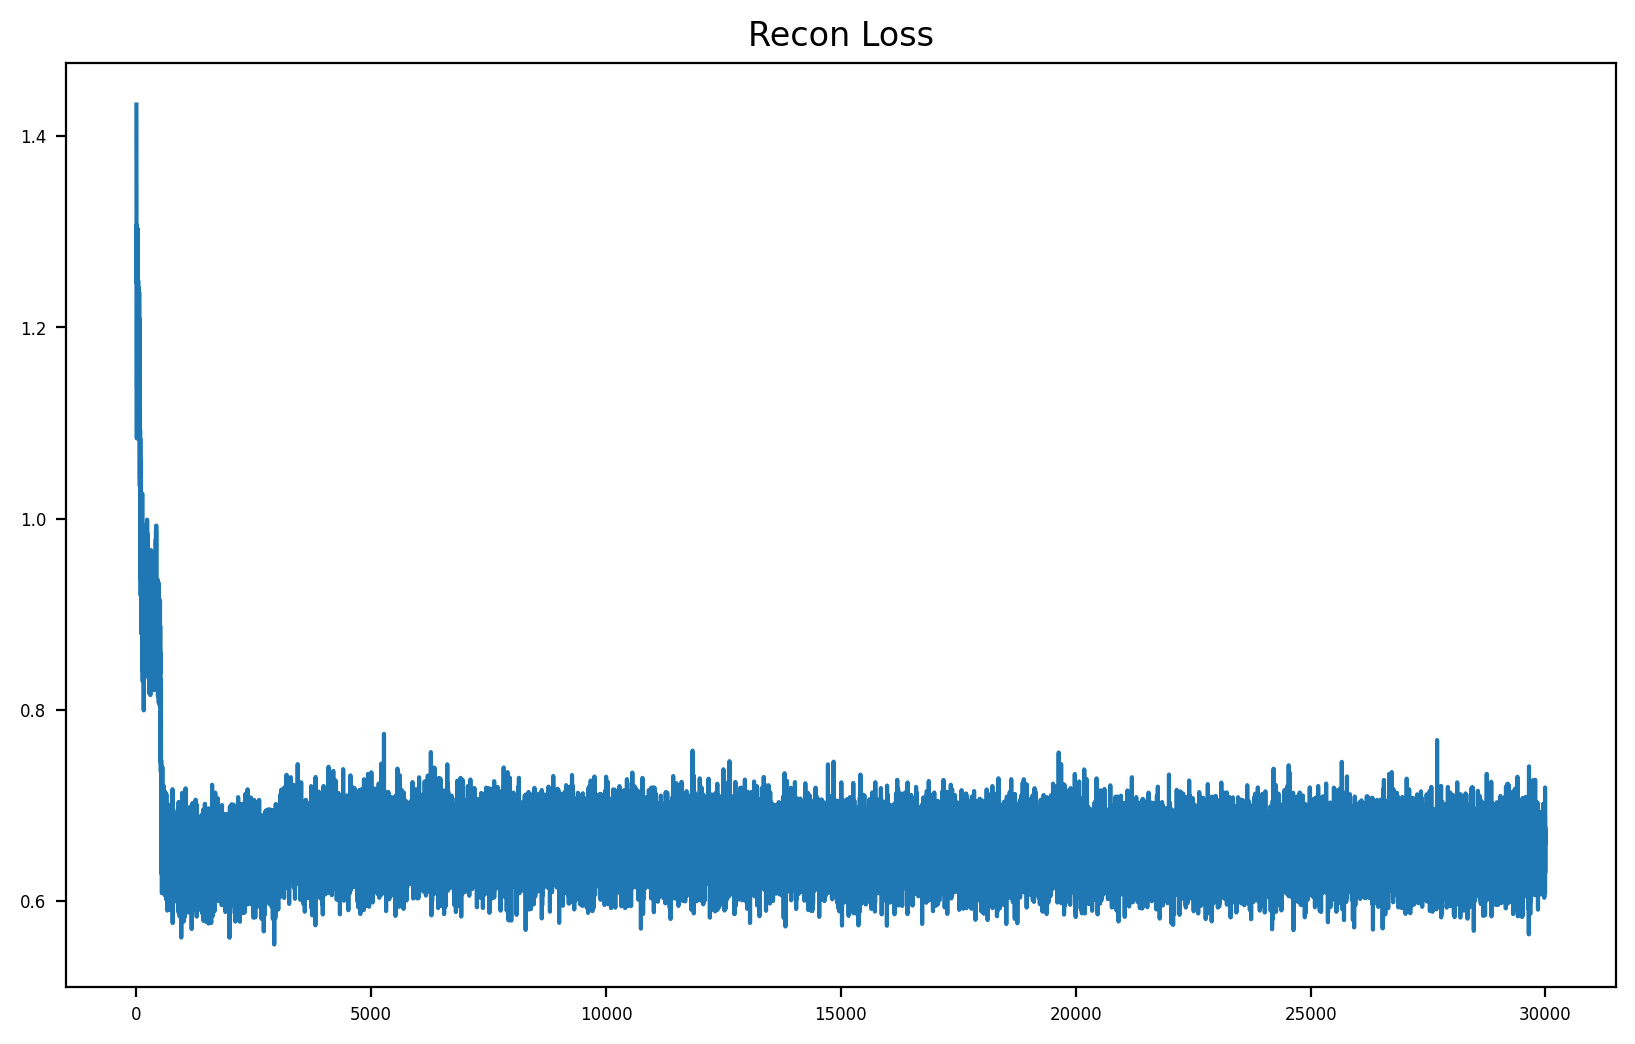

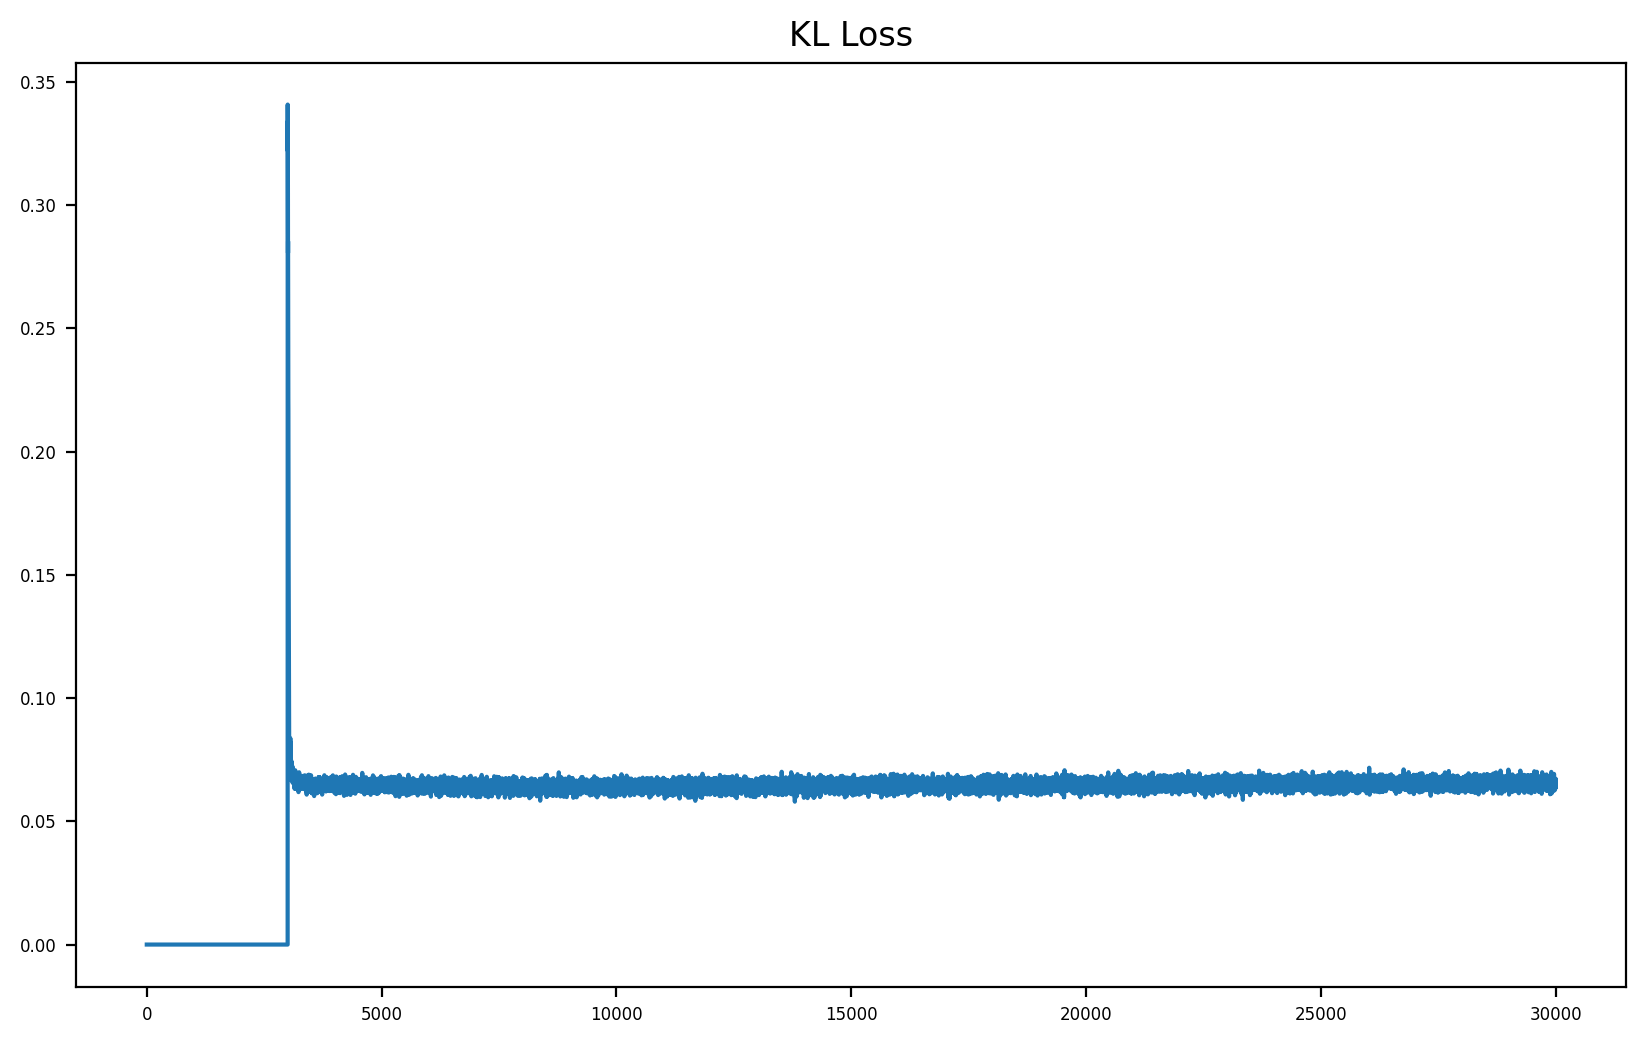

In [8]:
plt.figure(figsize=(10,6))
plt.plot(x_lst[:], loss_recon_lst[:])
plt.title("Recon Loss")
plt.show()
plt.figure(figsize=(10,6))
plt.plot(x_lst[:], loss_kl_lst[:])
plt.title("KL Loss")
plt.show()

In [8]:
model.load_state_dict(torch.load('./weights/np_v2_30000_2.pth'))
buffer = BufferClass(xdim=9, cdim=72, buffer_limit=5, device=device)
for idx, data in enumerate(training_data[:5]): 
    buffer.store(x=np.array(data["x"]).reshape(-1), c=data["c"], reward=data["reward"])

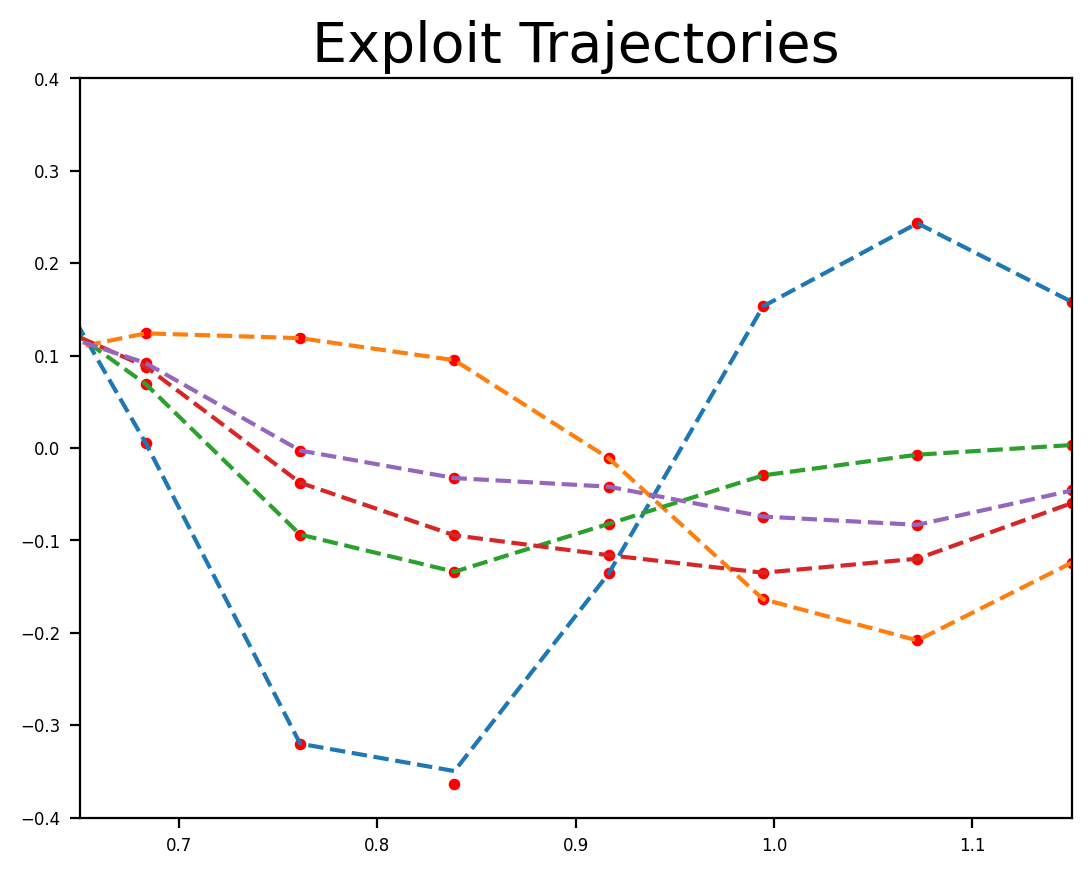

In [71]:
for i in range(5):
        batch = buffer.sample_batch(sample_method='random',
                                batch_size=1)
        anchor, z_sample = model.sample_x(c=batch["c"].reshape(1,-1), n_sample=1)
        anchor = np.insert(torch2np(anchor).reshape(-1), 0,0)
        grp = GaussianRandomPathClass(name = 'GRP',kernel = kernel_levse)
        t_test   = np.linspace(start=0.45,stop=1.15,num=10).reshape((-1,1))
        t_anchor = np.linspace(start=0.45,stop=1.15,num=10).reshape((-1,1))
        plt.scatter(t_test, anchor, s=10, color="r")
        anchor=anchor.reshape(-1)
        t_anchor=t_anchor.reshape(-1)

        grp.set_data(t_anchor= t_anchor.reshape((-1,1)),
                x_anchor = np.array([anchor]).T,
                l_anchor = np.array([[1,1,1,1,1,1,1,1,1,1]]).T,
                t_test   = t_test,
                l_test   = np.ones((len(t_test),1)),
                hyp_mean = {'g':0.1,'l':0.1,'w':1e-6},
                hyp_var  = {'g':0.1,'l':0.1,'w':1e-6})
        mean_traj, t_test = grp.mean_traj()
        plt.plot(t_test,mean_traj,'--')
plt.xlim(0.65, 1.15)
plt.ylim(-0.4,0.4)
plt.title("Exploit Trajectories", fontsize=20)
plt.show()

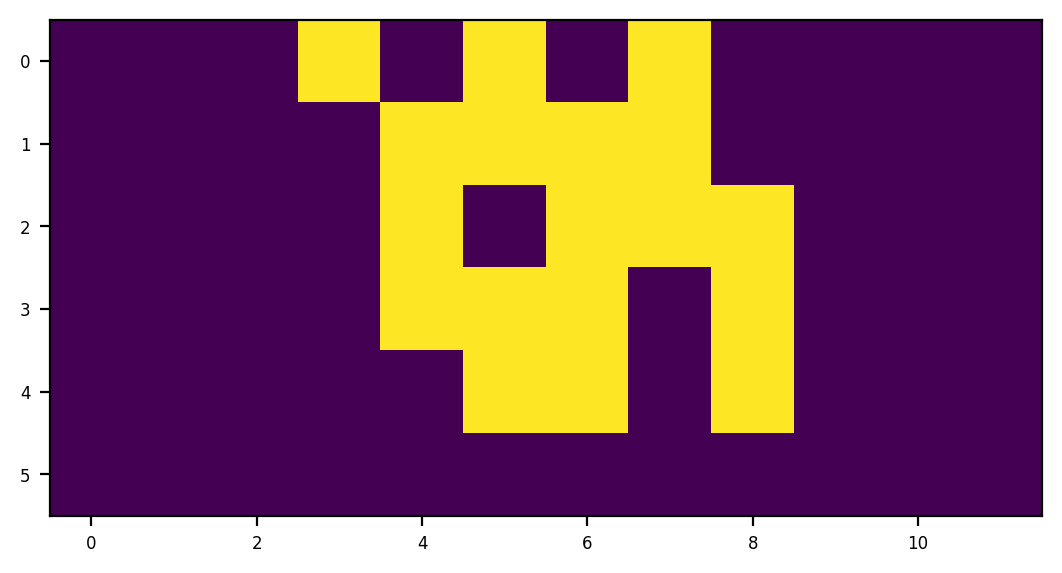

In [69]:
image = batch["c"][0].reshape(6,12)
plt.imshow(torch2np(image))

In [87]:
from util import rpy2r

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))

# Straight pose
DO_RENDER_IK = True
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
R_trgt = rpy2r(np.radians([-180,0,90]))
# init_configurations = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
env.forward(q=init_configurations,joint_idxs=env.idxs_forward)
q_ik_list = []

for (x_trgt, y_trgt) in zip(t_test, mean_traj):
    print(f"(x_trgt, y_trgt, z_trgt): ({x_trgt}, {y_trgt}, {0.81})")
    q_ik = env.solve_ik(
        body_name=body_name, p_trgt=np.array([x_trgt[0], y_trgt[0], 0.86]), R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=init_configurations, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER_IK, render_every=10, th=1*np.pi/180.0, err_th=1e-1)
    q_ik_list.append(q_ik)

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

(x_trgt, y_trgt, z_trgt): ([0.45], [0.], 0.81)
(x_trgt, y_trgt, z_trgt): ([0.53], [0.09], 0.81)
(x_trgt, y_trgt, z_trgt): ([0.61], [0.15], 0.81)
(x_trgt, y_trgt, z_trgt): ([0.68], [0.09], 0.81)
(x_trgt, y_trgt, z_trgt): ([0.76], [-0.], 0.81)
(x_trgt, y_trgt, z_trgt): ([0.84], [-0.03], 0.81)
(x_trgt, y_trgt, z_trgt): ([0.92], [-0.04], 0.81)
(x_trgt, y_trgt, z_trgt): ([0.99], [-0.07], 0.81)
(x_trgt, y_trgt, z_trgt): ([1.07], [-0.08], 0.81)
(x_trgt, y_trgt, z_trgt): ([1.15], [-0.05], 0.81)
Done. Tick:[3315] Time:[5.57]sec


In [88]:
q_ik_list = np.array(q_ik_list)
q_ik_list

array([[-0.74, -1.1 ,  2.8 , -1.7 ,  0.83, -0.  ],
       [-0.65, -1.09,  2.78, -1.69,  0.91,  0.  ],
       [-0.24, -1.04,  2.5 , -1.47,  1.31,  0.  ],
       [-0.31, -1.  ,  2.34, -1.36,  1.24,  0.01],
       [-0.42, -0.94,  2.16, -1.24,  1.14,  0.01],
       [-0.39, -0.86,  1.93, -1.1 ,  1.17,  0.01],
       [-0.34, -0.76,  1.68, -0.94,  1.22,  0.01],
       [-0.33, -0.65,  1.4 , -0.78,  1.24,  0.01],
       [-0.3 , -0.51,  1.09, -0.61,  1.27,  0.01],
       [-0.22, -0.3 ,  0.65, -0.37,  1.35,  0.  ]])

In [92]:
from util import get_interp_const_vel_traj

capture_pose = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])

times,q_traj = get_interp_const_vel_traj(
    q_ik_list,vel=np.radians(30),HZ=env.HZ)
print ("Joint trajectory ready. duration:[%.2f]sec"%(times[-1]))

times_return,q_return_traj = get_interp_const_vel_traj(
    np.vstack([q_ik_list[-1], capture_pose]),vel=np.radians(30),HZ=env.HZ)
print ("Joint trajectory ready. duration:[%.2f]sec"%(times[-1]))

Joint trajectory ready. duration:[4.49]sec
Joint trajectory ready. duration:[4.49]sec


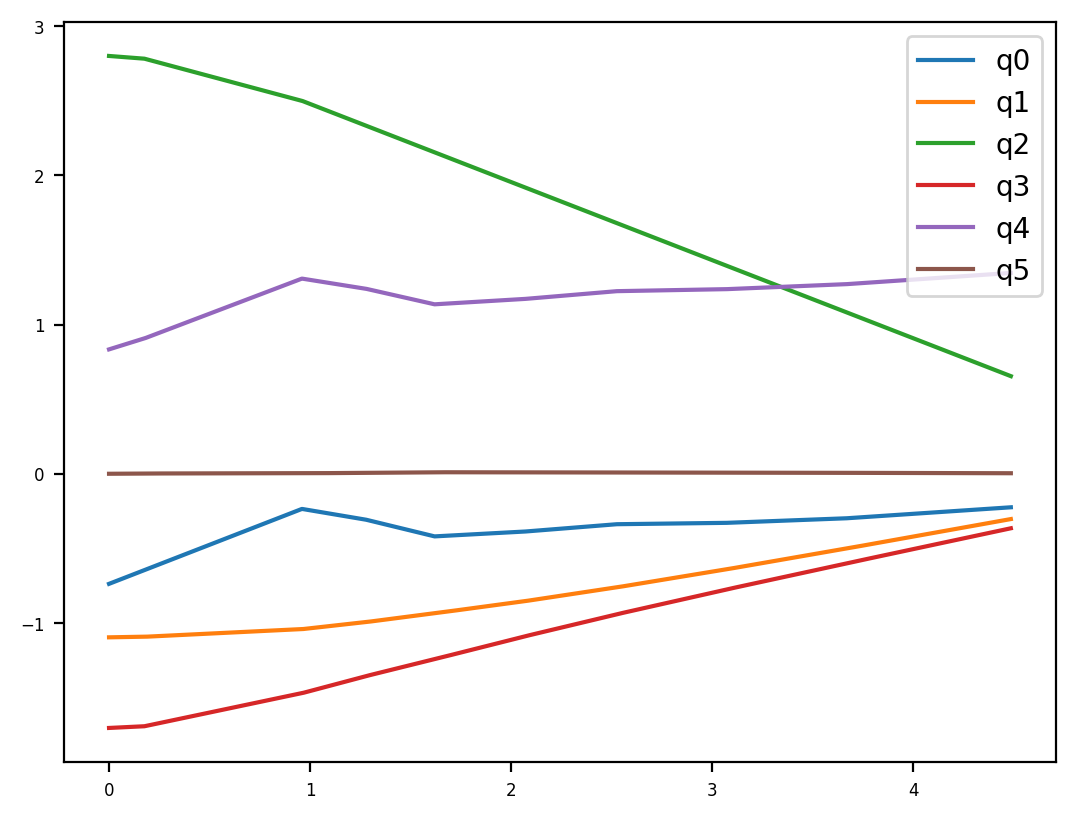

In [93]:
plt.plot(times,q_traj[:,0],label='q0')
plt.plot(times,q_traj[:,1],label='q1')
plt.plot(times,q_traj[:,2],label='q2')
plt.plot(times,q_traj[:,3],label='q3')
plt.plot(times,q_traj[:,4],label='q4')
plt.plot(times,q_traj[:,5],label='q5')
plt.legend()
plt.show()


In [97]:
from util import compute_view_params, rpy2r, meters2xyz
import cv2 

env.init_viewer(viewer_title='UR5e',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
R_trgt = rpy2r(np.radians([-180,0,90]))
env.forward(q=init_configurations,joint_idxs=env.idxs_forward)

tick = 0
tick_return = 0

while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    if tick >= len(q_traj):
        if tick_return >= len(q_return_traj):
            env.step(ctrl=q_return_traj[-1,:],ctrl_idxs=env.idxs_step)
        else:
            env.step(ctrl=q_return_traj[tick_return,:],ctrl_idxs=env.idxs_step)
        tick_return += 1
    else:
        env.step(ctrl=q_traj[tick,],ctrl_idxs=env.idxs_step)

    tick += 1

    # Compute some poses
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')

    # Get PCD from a specific view
    p_ego  = p_cam
    p_trgt = p_cam + R_cam[:,0]
    
    # To world coordinate
    T_cam = np.eye(4)
    T_cam[:3,:3] = R_cam
    T_cam[:3,3] = p_cam
    
    # rgb_img,depth_img,pcd, xyz_img = env.get_egocentric_rgb_depth_pcd(
    #     p_ego=p_ego,p_trgt=p_trgt,T_cam=T_cam,rsz_rate=100,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

    # for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0,1,0,1])
    env.render(render_every=5)

    # Plot
    # if env.loop_every(HZ=10):
    #     fig,axs = plt.subplots(1,3,figsize=(10,2))
    #     scene_img = env.grab_image()
    #     axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
    #     fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
    #     plt.subplots_adjust(wspace=0.2); plt.show()

# Close viewer
env.close_viewer()
print ("Done.")

Pressed ESC
Quitting.
Done.


In [55]:
q_traj.shape

(2999, 6)